In [1]:
library("tidyverse")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Figure 2

## code

In [43]:
disease <- read_tsv("./results/MRDN_nodes_category.txt")
fullname <- c("Bacterial Infections and Mycoses", 
              "Neoplasms", 
              "Cardiovascular Diseases", 
              "Digestive System Diseases", 
              "Hemic and Lymphatic Diseases", 
              "Immune System Diseases", 
              "Nutritional and Metabolic Diseases", 
              "Musculoskeletal Diseases", 
              "Nervous System Diseases", 
              "Parasitic Diseases", 
              "Respiratory Tract Diseases", 
              "Skin and Connective Tissue Diseases", 
              "Urogenital Diseases and Pregnancy Complications", 
              "Virus Diseases", 
              "Others"
             )
disease["Category"] <- factor(disease$Category, ordered=TRUE, levels=fullname)

Parsed with column specification:
cols(
  Nodes = col_character(),
  Category = col_character()
)



In [46]:
f2a <- ggplot(disease, aes(Category, fill=Category)) + 
    geom_bar(stat="count") + 
    scale_fill_manual(values=c("#ff6600", 
                               "#ff00cc", 
                               "#ffcc00", 
                               "#ccff00", 
                               "#ff3333", 
                               "#00ff00", 
                               "#00ff66", 
                               "#00ffcc", 
                               "#00ccff", 
                               "#0000ff", 
                               "#6600ff", 
                               "#cc00ff", 
                               "#ff0066", 
                               "#ff0000", 
                               "#aaaaaa"
                              )) + 
    labs(x="Disease Classes", y="Count") + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"), 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(),
          legend.title = element_blank()
         )

In [57]:
exp_data <- read_tsv("./results/HMDD_tissue.txt")
exp_data <- exp_data %>%
    group_by(`pri-miRNA`, disease) %>%
    summarize(regulation=sum(regulation)) %>%
    filter(regulation != 0)

Parsed with column specification:
cols(
  `pri-miRNA` = col_character(),
  disease = col_character(),
  regulation = col_double()
)



In [75]:
mir <- exp_data %>%
    group_by(`pri-miRNA`) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10) %>%
    mutate(group="mir", name=`pri-miRNA`)
disease <- exp_data %>%
    group_by(disease) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10) %>%
    mutate(group="disease", name=disease)
cnt <- bind_rows(mir, disease)
cnt["name"] <- factor(cnt$name, ordered=TRUE, levels=cnt$name)

In [86]:
f2bc <- ggplot(cnt, aes(x=name, y=count, fill=group)) + 
    geom_col() + 
    scale_fill_manual(values = c("steelblue", "tomato")) + 
    guides(fill=FALSE) + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"), 
          axis.text.x = element_text(hjust=1, angle=45)
         ) + facet_wrap(. ~ group, scales="free")

## plot

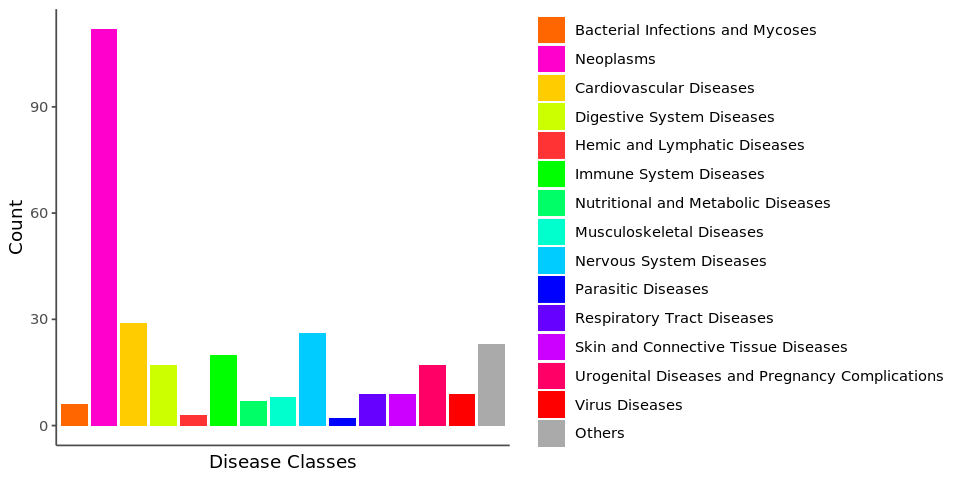

In [78]:
options(repr.plot.width=8, repr.plot.height=4)
f2a

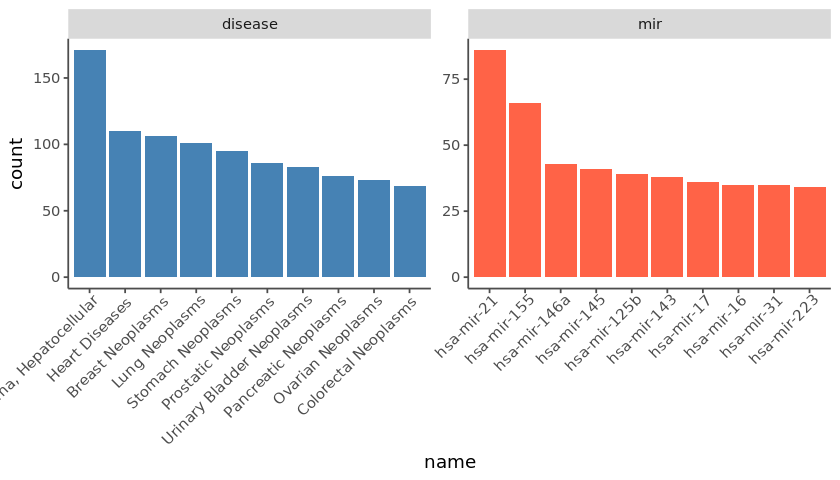

In [88]:
options(repr.plot.width=7, repr.plot.height=4)
f2bc

# Figure 3

## code

In [133]:
node.info <- read_tsv("./results/MRDN_nodes_property.txt")

Parsed with column specification:
cols(
  Nodes = col_character(),
  Category = col_character(),
  Degree = col_double(),
  Positive_Edge = col_double(),
  Negative_Edge = col_double(),
  Cluster_Coefficient = col_double()
)



In [146]:
pnmod <- lm(Negative_Edge ~ Positive_Edge, node.info)
s <- summary(pnmod)
itc <- s$coefficients['(Intercept)', 'Estimate']
bx <- s$coefficients['Positive_Edge', 'Estimate']
lmfunc <- function (x){
    a <- as.numeric(x[4])
    b <- as.numeric(x[5])
    return(bx*a-b+itc)
}
node.info['distance'] <- apply(node.info, 1, lmfunc)

In [147]:
cor.test(node.info$Positive_Edge, node.info$Negative_Edge, method="pearson")


	Pearson's product-moment correlation

data:  node.info$Positive_Edge and node.info$Negative_Edge
t = 8.5259, df = 302, p-value = 7.385e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3450611 0.5268446
sample estimates:
      cor 
0.4404563 


In [149]:
f3b <- ggplot(node.info, aes(Positive_Edge, Negative_Edge)) + 
    geom_point(aes(color=distance)) + 
    scale_color_gradient2(low="steelblue", high="tomato", midpoint=0, limits=c(-20, 20)) + 
    geom_smooth(method="lm") + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"),
         ) + 
    geom_text(data=head(arrange(node.info, distance)), 
              mapping=aes(x=Positive_Edge, y=Negative_Edge, label=Nodes), 
              size=2,
              position="jitter"
             ) + 
    geom_text(data=head(arrange(node.info, desc(distance))),
              mapping=aes(x=Positive_Edge, y=Negative_Edge, label=Nodes), 
              size=2,
              position="jitter"
             )

In [171]:
disf <- read_tsv("./results/MRDN_Distance.txt")
disf <- disf[disf$Distance!=0, ]
pst <- function(x){
    vec <- sort(as.vector(x))
    res <- paste(vec[1], vec[2], sep=".2.")
    return(res)
}
disf['pair'] <- as.vector(apply(disf[,c(1,2)], 1, pst))
disf <- disf[!duplicated(disf$pair), ]


Parsed with column specification:
cols(
  From = col_character(),
  To = col_character(),
  Distance = col_double(),
  Type = col_character()
)



In [172]:
res <- t.test(disf[["Distance"]][disf$Type=="intra"], disf[["Distance"]][disf$Type=="inter"])
res


	Welch Two Sample t-test

data:  disf[["Distance"]][disf$Type == "intra"] and disf[["Distance"]][disf$Type == "inter"]
t = -11.616, df = 11366, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.12486742 -0.08880933
sample estimates:
mean of x mean of y 
 2.474866  2.581704 


In [173]:
res$p.value

[1] 5.127057e-31

In [170]:
disf

From,To,Distance,Type,pair
<chr>,<chr>,<dbl>,<ord>,<chr>
"Abortion, Habitual",Acquired Immunodeficiency Syndrome,3,NA,"Abortion, Habitual.2.Acquired Immunodeficiency Syndrome"
"Abortion, Habitual",Acute Kidney Injury,3,NA,"Abortion, Habitual.2.Acute Kidney Injury"
"Abortion, Habitual",Acute Lung Injury,3,NA,"Abortion, Habitual.2.Acute Lung Injury"
"Abortion, Habitual","Adenocarcinoma, Esophageal",3,NA,"Abortion, Habitual.2.Adenocarcinoma, Esophageal"
"Abortion, Habitual","Adenocarcinoma, Lung",3,NA,"Abortion, Habitual.2.Adenocarcinoma, Lung"
"Abortion, Habitual",Adenoviridae Infections,4,NA,"Abortion, Habitual.2.Adenoviridae Infections"
"Abortion, Habitual",Adrenal Cortex Neoplasms,2,NA,"Abortion, Habitual.2.Adrenal Cortex Neoplasms"
"Abortion, Habitual",Adrenocortical Carcinoma,3,NA,"Abortion, Habitual.2.Adrenocortical Carcinoma"
"Abortion, Habitual",Alopecia,4,NA,"Abortion, Habitual.2.Alopecia"


In [176]:
disf['Type'] <- factor(disf$Type, ordered=TRUE, levels=c("intra", "inter"))
f3c <- ggplot(disf, aes(x=Type, y=Distance, color=Type, fill=Type)) + 
    geom_violin(scale="area", show.legend=FALSE) + 
    scale_y_continuous(breaks=seq(0,7,1), limits=c(0, 7)) + 
    scale_color_brewer(palette="Set1") +
    scale_fill_brewer(palette="Set1") + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30")
         )

## plot

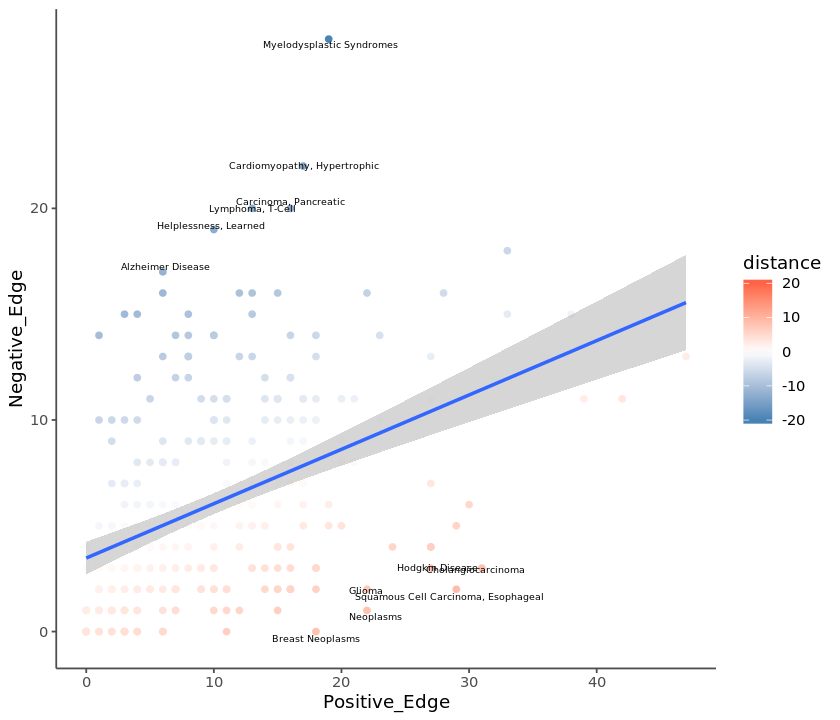

In [150]:
options(repr.plot.width=7, repr.plot.height=6)
f3b

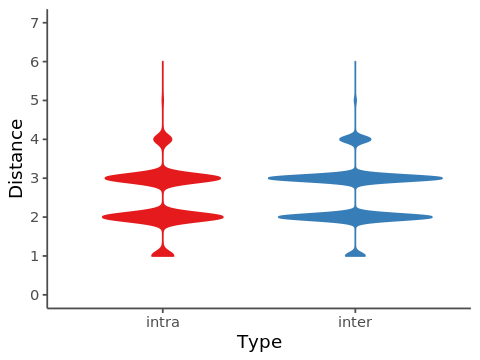

In [175]:
options(repr.plot.width=4, repr.plot.height=3)
f3c

# Fisher Test

In [177]:
disf <- read_tsv("./results/MRDN_diseases.txt")

Parsed with column specification:
cols(
  d1 = col_character(),
  d2 = col_character(),
  similarity = col_double(),
  d1_class = col_character(),
  d2_class = col_character(),
  same_class = col_logical()
)



In [188]:
disf <- disf %>%
    mutate(simabs=abs(similarity))
within_inter <- nrow(disf[(disf$simabs>0.05)&(!disf$same_class),])/2
within_intra <- nrow(disf[(disf$simabs>0.05)&(disf$same_class),])/2
without_inter <- nrow(disf[(disf$simabs<=0.05)&(!disf$same_class),])/2
without_intra <- nrow(disf[(disf$simabs<=0.05)&(disf$same_class),])/2
c(within_inter, within_intra, without_inter, without_intra)

[1]  1829   611 36075  7541

In [189]:
fisher.test(matrix(c(within_intra, within_inter, without_intra, without_inter), nrow=2, byrow=T))$p.value

[1] 1.015729e-20

In [191]:
disfi <- disf %>% filter(simabs > 0.05)
pa <- nrow(disfi[(disfi$similarity>0)&(disfi$same_class),])/2
pe <- nrow(disfi[(disfi$similarity>0)&(!disfi$same_class),])/2
na <- nrow(disfi[(disfi$similarity<0)&(disfi$same_class),])/2
ne <- nrow(disfi[(disfi$similarity<0)&(!disfi$same_class),])/2
c(pa, na, pe, ne)

[1]  432  179 1089  740

In [192]:
fisher.test(matrix(c(pa, pe, na, ne), nrow=2, byrow=TRUE))$p.value

[1] 6.590614e-07

# coherent

## code

In [211]:
coh_shuffle <- read.table("./results/coherent/MRDN_Coherent_Shuffle.txt", sep="\t", header=TRUE)
coh_shuffle['method'] <- "shuffle"
coh_rewiring <- read.table("./results/coherent/MRDN_Coherent_Rewiring.txt", sep="\t", header=TRUE)
coh_rewiring['method'] <- "rewiring"
coh <- rbind(coh_shuffle, coh_rewiring)

In [212]:
aggregate(coh[, c(1:3)], by=list(factor(coh$method)), FUN=mean)

Group.1,all,coherent,ratio
<fct>,<dbl>,<dbl>,<dbl>
rewiring,688.5768,349.4877,1.033769
shuffle,1537.5595,1378.3460,8.720209


In [213]:
t.test(x=coh_shuffle$ratio, mu=16.02)


	One Sample t-test

data:  coh_shuffle$ratio
t = -889.08, df = 9999, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 16.02
95 percent confidence interval:
 8.704115 8.736303
sample estimates:
mean of x 
 8.720209 


In [214]:
cohp <- ggplot(coh, aes(x=ratio)) + 
    geom_smooth(stat="density", size=0.5) + 
    scale_x_continuous(limits=c(6,18), breaks=seq(6,18,2)) + 
    theme(panel.background = element_blank(), 
          panel.grid = element_blank(), 
          axis.line = element_line(color="gray30"), 
          axis.ticks = element_line(color="gray30"), 
          axis.text = element_text(color="gray30"),
         ) + 
    facet_wrap(. ~ method, scales="free") + 
    annotate("segment", x=16, xend=16, y=0.2, yend=0.05, arrow=arrow(length=unit(3,"mm")), size=0.6, color="firebrick3")


## plot

Warning message:
“Removed 10000 rows containing non-finite values (stat_density).”


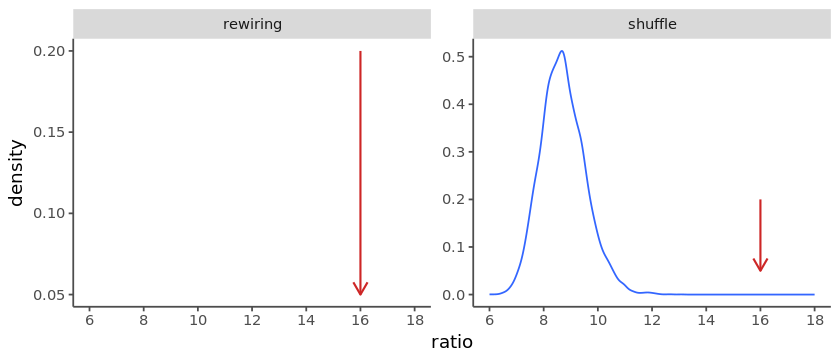

In [215]:
options(repr.plot.width=7, repr.plot.height=3)
cohp

# Figure 4

## code

In [228]:
mirmat <- read.table("./results/HMDD_similarity_matrix.txt", sep="\t", header=TRUE, row.names=1, check.names = FALSE, quote = "")

In [229]:
dname <- 'Aortic Aneurysm, Abdominal'
omat <- mirmat[order(mirmat[, dname]), c('Aortic Aneurysm, Abdominal', dname)]
vmat <- rbind(head(omat, 10), tail(omat, 11)[-11, ])
colnames(vmat) <- c("aaa", "disease")
vmat['xlab'] <- factor(rownames(vmat), ordered=TRUE, levels=rownames(vmat))
vmat['group'] <- factor(cut(vmat$disease, c(-1, 0, 1), labels=c("opposite", "similar")), 
                        ordered=TRUE, levels=c("similar", "opposite"))
simp <- ggplot(vmat, aes(x = xlab, y = disease, fill = group)) + 
  geom_col() + 
  scale_fill_manual(values=c("steelblue2", "firebrick1")) + 
  labs(x="Disease", y="Simiarity", title=dname) + 
  theme(panel.background = element_blank(), 
        panel.grid = element_blank(), 
        legend.position = "none", 
        axis.ticks.y = element_blank(), 
        plot.title = element_text(size=10)) + 
  coord_flip()

## plot

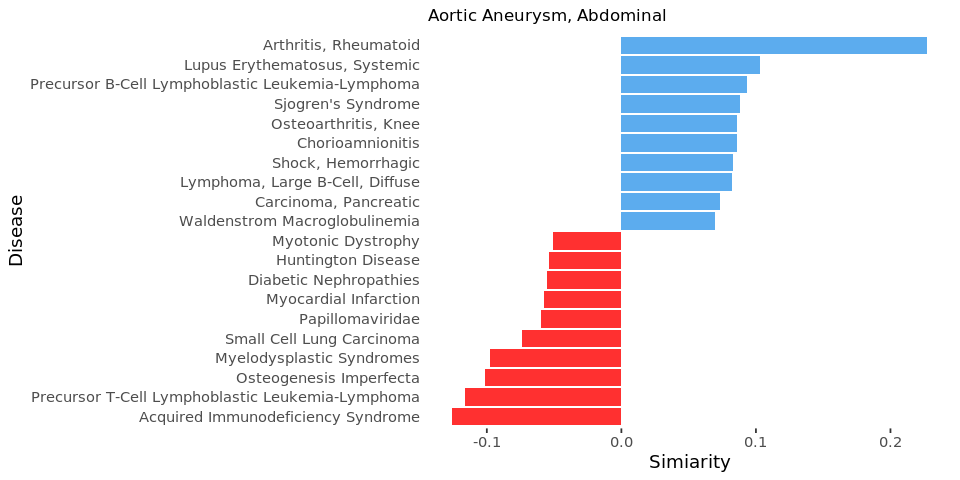

In [230]:
options(repr.plot.width=8, repr.plot.height=4)
simp

# Table S1

## code

In [105]:
exp_data <- read_tsv("./results/HMDD_tissue.txt")
dcategory <- read_tsv("./results/MRDN_nodes_category.txt")
dcategory <- dcategory %>%
    rename(disease=Nodes)
exp_data <- exp_data %>%
    group_by(`pri-miRNA`, disease) %>%
    summarize(regulation=sum(regulation)) %>%
    filter(regulation != 0) %>%
    left_join(dcategory)
mir <- exp_data %>%
    group_by(`pri-miRNA`) %>%
    summarize(count=n()) %>%
    arrange(desc(count)) %>%
    head(n=10)
ts1 <- exp_data %>%
    group_by(`pri-miRNA`, Category) %>%
    summarize(count=n()) %>%
    filter((Category == "Neoplasms") | (Category == "Cardiovascular Diseases")) %>%
    spread(key=Category, value=count) %>%
    right_join(mir)

Parsed with column specification:
cols(
  `pri-miRNA` = col_character(),
  disease = col_character(),
  regulation = col_double()
)

Parsed with column specification:
cols(
  Nodes = col_character(),
  Category = col_character()
)

Joining, by = "disease"
Joining, by = "pri-miRNA"


## table

In [106]:
ts2

pri-miRNA,Cardiovascular Diseases,Neoplasms,count
<chr>,<int>,<int>,<int>
hsa-mir-21,10,50,86
hsa-mir-155,6,33,66
hsa-mir-146a,2,18,43
hsa-mir-145,2,31,41
hsa-mir-125b,1,19,39
hsa-mir-143,1,21,38
hsa-mir-17,1,28,36
hsa-mir-16,1,22,35
hsa-mir-31,2,30,35
